## **SML FINAL PROJECT: PCA with KNN on Breast Cancer Dataset**
### Author - Velamuri Yoganandam
---
This file contains the implementation of PCA with KNN on Breast Cancer Dataset
All the cells in the file must be executed in the same order for the code to run without any errors.


In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

def load_dataset():
  # fetch dataset
  breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

  # data (as pandas dataframes)
  X = breast_cancer_wisconsin_diagnostic.data.features
  y = breast_cancer_wisconsin_diagnostic.data.targets

  # metadata
  print(breast_cancer_wisconsin_diagnostic.metadata)

  # variable information
  print(breast_cancer_wisconsin_diagnostic.variables)
  return X, y

X_raw, y_raw = load_dataset()

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'published_in': 'Electronic imaging', 'year': 1993, 'url': 'https://www.semanticscholar.org/paper/53

Data Distribution: 
 Diagnosis
B    357
M    212
dtype: int64
Missing feature values:  0


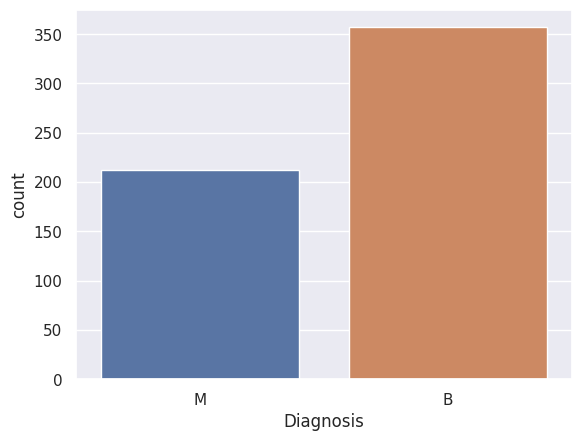

In [3]:
import plotly.offline as pyo
import plotly.graph_objs as go
import seaborn as sns
# Visualize data
sns.set()
sns.countplot(data=X_raw, x=y_raw.Diagnosis)
print("Data Distribution: \n",y_raw.groupby('Diagnosis').size())
# B - Benign, M - Malignant
# Display Metadata
print("Missing feature values: ",X_raw.isnull().sum().sum())
y_m, y_b = y_raw[y_raw.Diagnosis == 'M'], y_raw[y_raw.Diagnosis == 'B']
labels = ["M","B"]
values = [len(y_m),len(y_b)]
trace = [go.Pie(labels=labels, values=values,
              marker=dict(colors=["red","green"]))]
layout = go.Layout(title="Percentage of M = malignant, B = benign ", width=500, height=500)
fig = go.Figure(data=trace,layout=layout)
pyo.iplot(fig)

From the data, we can observe we do not have any missing values. The only preprocesing we need to perform, would be to assign numerical values to the categorical values.

In [4]:
def preprocess(features, labels):
  # Extract features into X
  X = features.copy()

  # Extract labels into Y
  y = labels.copy()
  # Assign numerical values to labels
  y.replace(to_replace=['M', 'B'], value=[1, 0], inplace=True)

  return X, y

In [5]:
X, y = preprocess(X_raw, y_raw)

# Split data into train and test

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classification with K-Nearest Neigbors

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data set has only numerical features, we can scale all of them with standard scaler
scaler = StandardScaler()
knn = KNeighborsClassifier()

pipe = Pipeline(
    [
        ("scaler", scaler),
        ("PCA", PCA(n_components = 0.95, svd_solver='full')),
        ("KNN", knn)
    ]
)

# Left 1 out of these values to avoid overfitting.
# Used only odd k values to avoid ties at the decision boundary
k_vals = np.arange(3,31,2)
pca_n_vals = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# 10-Fold Cross Validation
param_grid = {
    'KNN__n_neighbors': k_vals,
    'PCA__n_components': pca_n_vals
}

# Define the GridSearchCV object with k-fold cross-validation
grid_search = GridSearchCV(pipe, param_grid,
                           cv=10,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True) # Helps plot data

# Perform grid search
grid_search.fit(x_train, y_train.to_numpy().reshape(-1,)).score(x_test, y_test)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


0.956140350877193

# Summary of PCA with KNN on Breast Cancer Dataset

In [8]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated score (accuracy): {:.2f}".format(grid_search.best_score_))

best_knn = grid_search.best_estimator_
test_score = best_knn.score(x_test, y_test.to_numpy().reshape(-1,))
print("Test set accuracy: {:.2f}".format(test_score))

print(f"Total features: {x_train.shape[1]}, Principal components chosen: {best_knn.named_steps.PCA.n_components_}")

Best parameters found:  {'KNN__n_neighbors': 5, 'PCA__n_components': 0.95}
Best cross-validated score (accuracy): 0.96
Test set accuracy: 0.96
Total features: 30, Principal components chosen: 10


In [27]:
def plot_per_hyperparam(hyperparam1, hyperparam2, hyp2_vals, label, xlabel, leg_title):
  # Retrieve the mean test scores from the cv_results
  mean_test_scores = grid_search.cv_results_['mean_test_score']
  mean_train_scores = grid_search.cv_results_['mean_train_score']

  # Get the list of hyperparameters settings from cv_results
  param_settings = [params for params in grid_search.cv_results_['params']]

  # Initialize a plot
  plt.figure(figsize=(10, 6))

  # Plot a curve for each value of PCA__n_components
  for hyp2_val in hyp2_vals:
      # Filter scores for the specific value of PCA__n_components
      scores = [mean_test_scores[i] for i in range(len(param_settings))
                if param_settings[i][hyperparam2] == hyp2_val]

      # Extract the KNN__n_neighbors values for plotting
      neighbors_values = [param_settings[i][hyperparam1] for i in range(len(param_settings))
                          if param_settings[i][hyperparam2] == hyp2_val]
      # Plot accuracy on y-axis and hyperparameters on x-axis
      plt.plot(neighbors_values, scores, marker='o', label=f'{label}={hyp2_val}')
  # Label the axes
  plt.xlabel(xlabel=xlabel)
  plt.ylabel('Accuracy')
  plt.title('Test Accuracy vs. Number of Neighbors')

  # Show the legend
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title=leg_title)
  plt.tight_layout()

  # Show the plot
  plt.show()

  plt.figure(figsize=(10, 6))
  for hyp2_val in hyp2_vals:
      # Filter scores for the specific value of PCA__n_components
      scores = [mean_train_scores[i] for i in range(len(param_settings))
                if param_settings[i][hyperparam2] == hyp2_val]

      # Extract the KNN__n_neighbors values for plotting
      neighbors_values = [param_settings[i][hyperparam1] for i in range(len(param_settings))
                          if param_settings[i][hyperparam2] == hyp2_val]
      plt.plot(neighbors_values, scores, marker='o', label=f'{label}={np.round(hyp2_val,2)}')
  # Label the axes
  plt.xlabel(xlabel=xlabel)
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy vs. Number of Neighbors')

  # Show the legend
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title=leg_title)
  plt.tight_layout()

  # Show the plot
  plt.show()

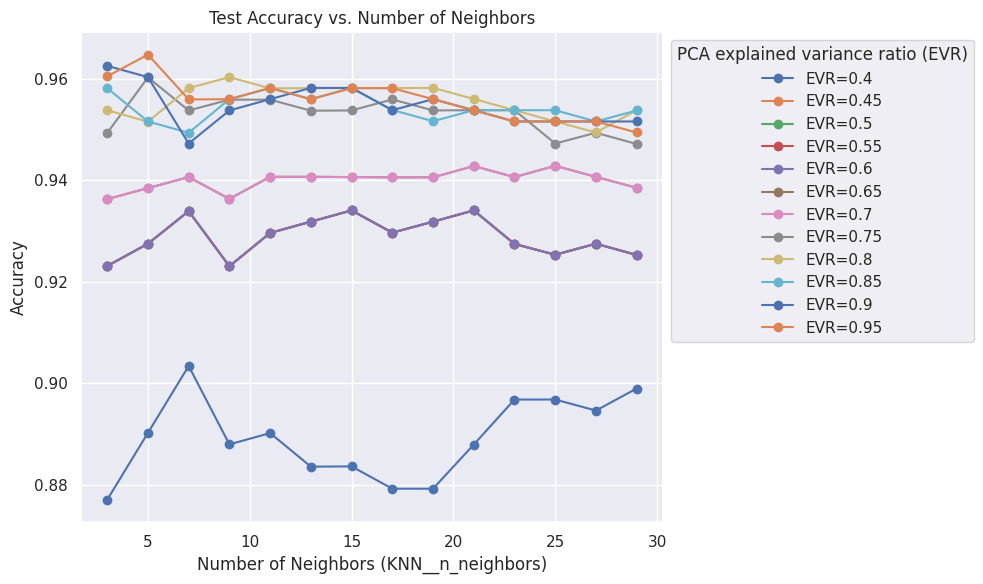

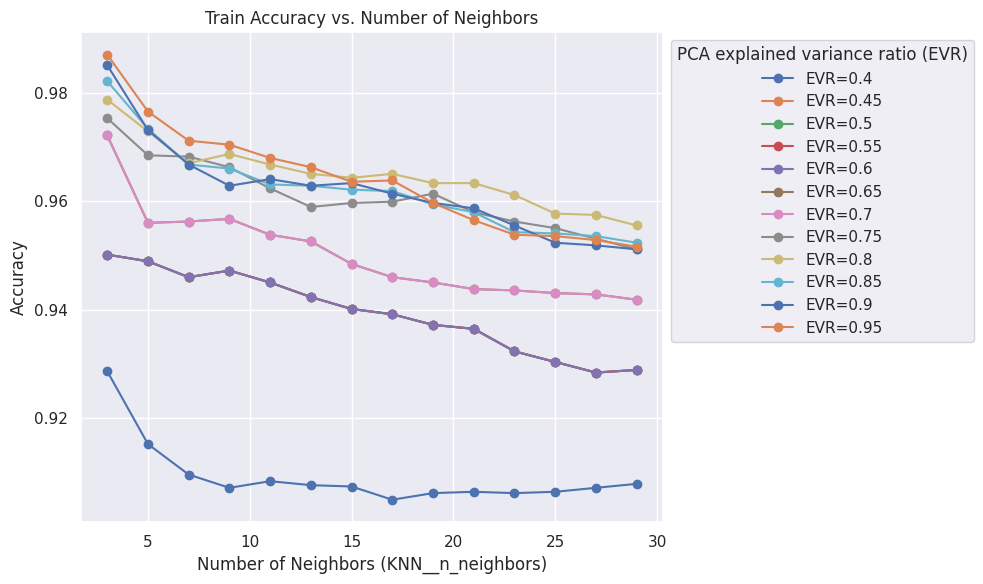

In [28]:
plot_per_hyperparam('KNN__n_neighbors', 'PCA__n_components', pca_n_vals, 'EVR', 'Number of Neighbors (KNN__n_neighbors)', 'PCA explained variance ratio (EVR)')


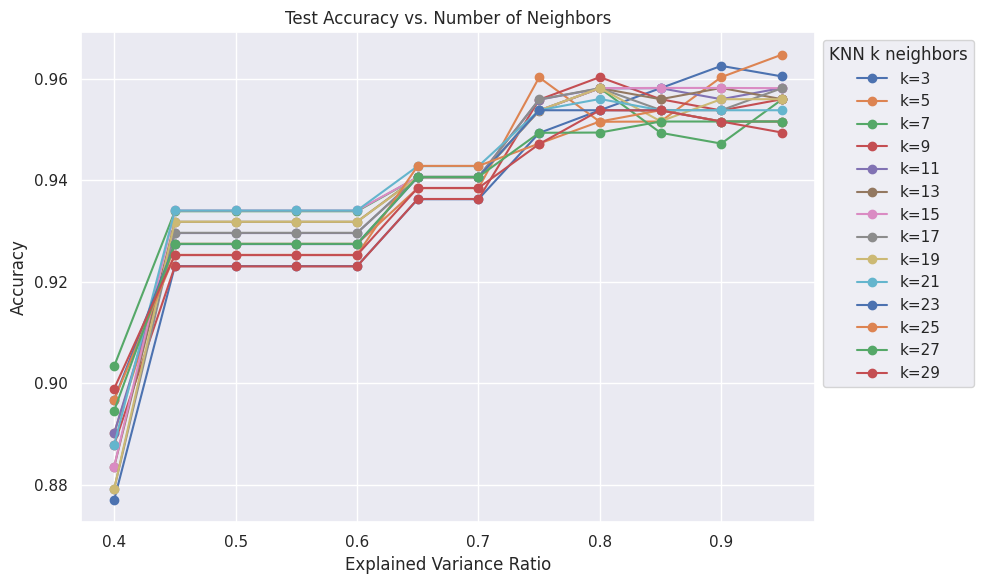

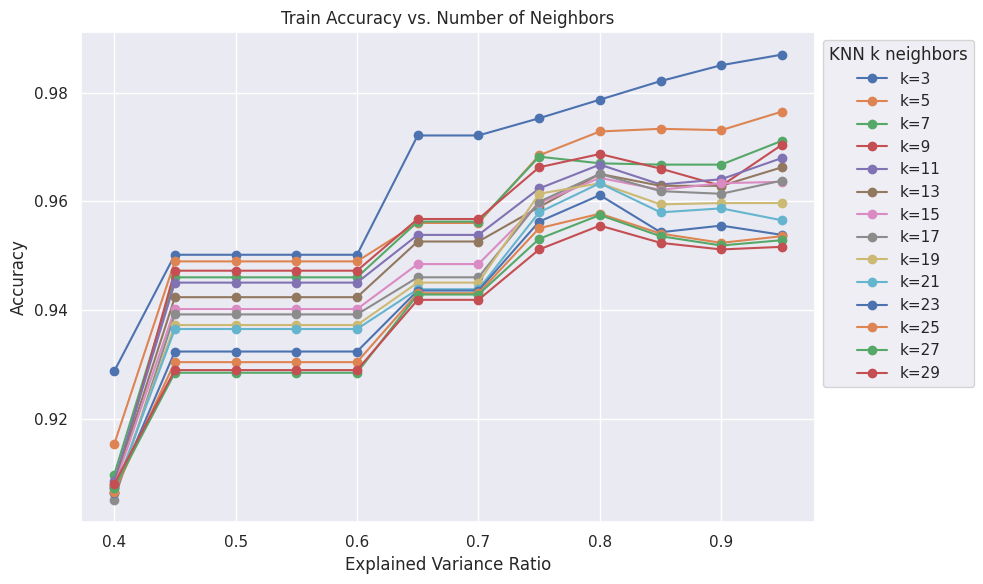

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plot_per_hyperparam('PCA__n_components', 'KNN__n_neighbors', k_vals, 'k', 'Explained Variance Ratio', 'KNN k neighbors')


<Axes: >

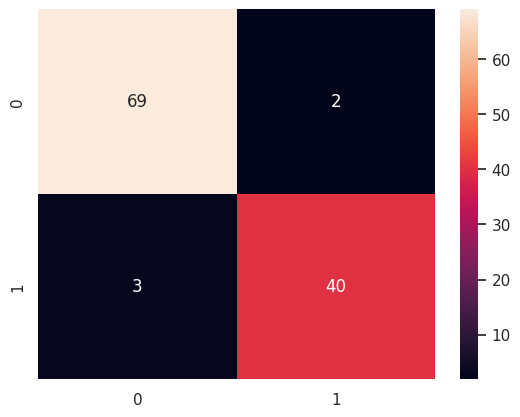

In [30]:
from sklearn.metrics import confusion_matrix
best_model = best_knn
y_predict_scaled = best_knn.predict(x_test)
cm = confusion_matrix(y_test, y_predict_scaled)
sns.heatmap(cm, annot=True)

# Visualizing contribution of each feature to the principal components

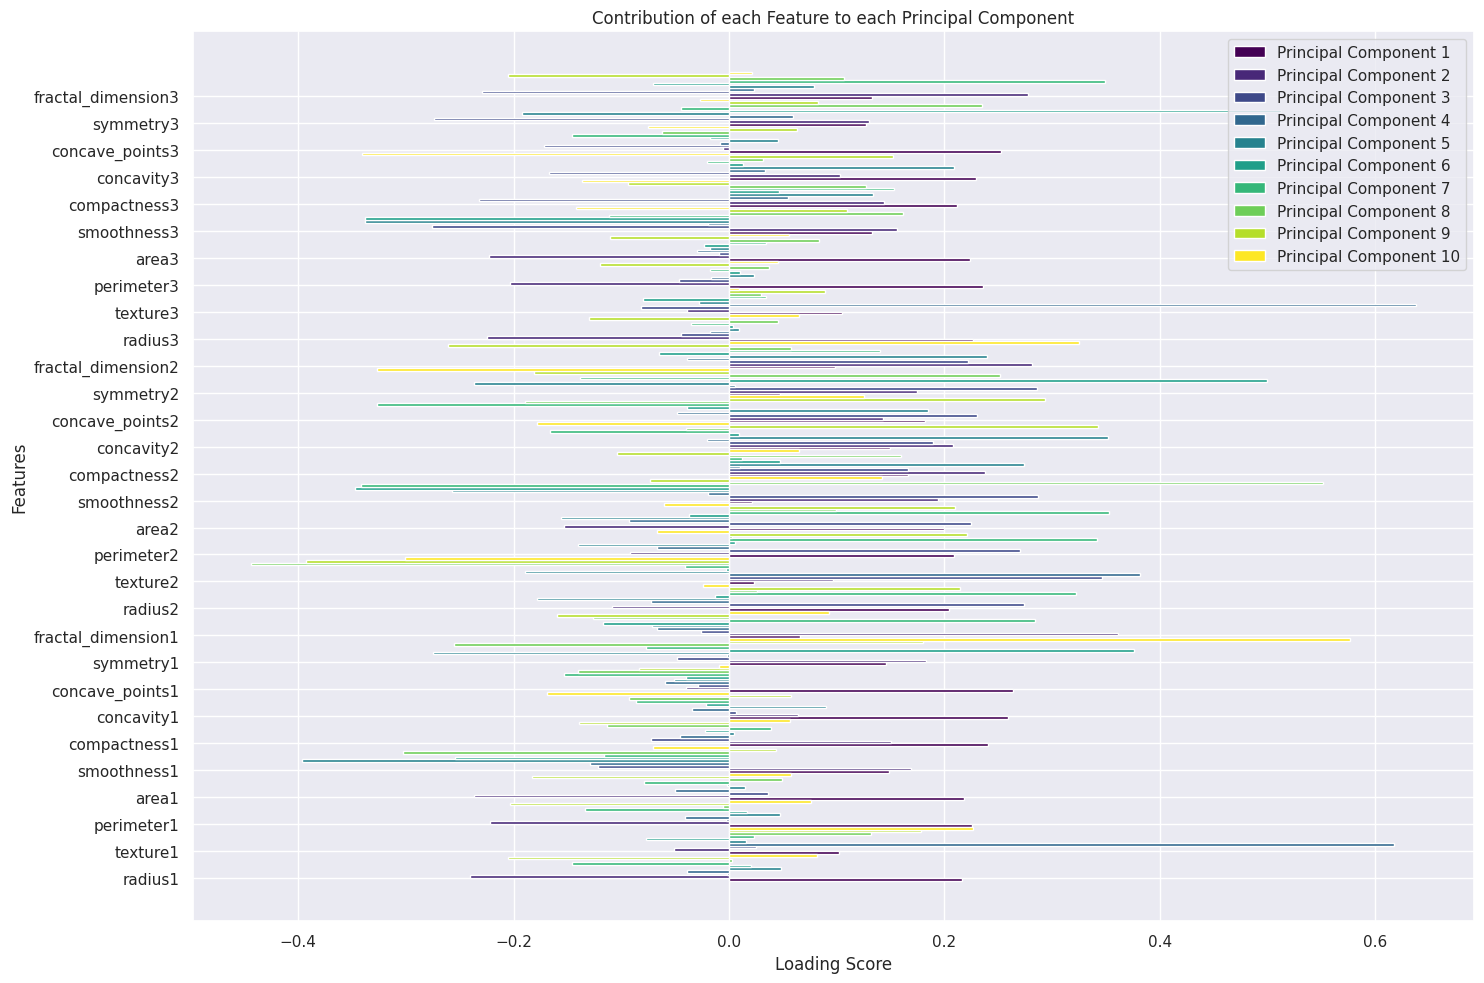

In [13]:
import matplotlib.pyplot as plt
import numpy as np

components = best_knn.named_steps['PCA'].components_
n_components = components.shape[0]
n_features = components.shape[1]

# Set up the figure size
plt.figure(figsize=(15, 10))

# Create a color map for the bars
colors = plt.cm.viridis(np.linspace(0, 1, n_components))

# Set the positions of the bars on the y-axis
ind = np.arange(n_features)
height = 0.1  # the height of the bars

# Plotting the contribution of each feature to each principal component
for i, (component, color) in enumerate(zip(components, colors)):
    component_features = dict(zip(X.columns, component))
    scores = list(component_features.values())
    plt.barh(ind + i * height, scores, height, label=f'Principal Component {i + 1}', color=color)

# Add some text for labels, title, and custom y-axis tick labels, etc.
plt.ylabel('Features')
plt.xlabel('Loading Score')
plt.title('Contribution of each Feature to each Principal Component')

# Define the position of the y-ticks
plt.yticks(ind + height / 2, X.columns)

# Adding legends
plt.legend(loc='best')

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
